In [55]:
import glob, os
import shutil
import matplotlib.pyplot as plt

import numpy as np
import librosa
from pathlib import Path

import pandas as pd

from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from librosa.feature import melspectrogram
from librosa.display import specshow
'''
'''
#TODO: export requirements

'\n'

In [56]:
#Load Dataset
'''
According to esc50 documentation rooster class is = 1.
'''
#50 CLASSES SOUND DATA SET
AUDIO_DS_PATH = Path("Data/Dataset/audio")
DF_PATH =  Path("Data/Dataset/esc50.csv")

#Dataset as pandas dataframe
sdf = pd.read_csv(DF_PATH)

print("Number of entries in Data frame: ", len(sdf.index))
# Count number of rows in a dataframe that contains NaN any column
seriesObj = sdf.apply(lambda x: x.isnull().any(), axis=1)
numOfRows = len(seriesObj[seriesObj == True].index)
print('Number of Rows in dataframe which contain NaN in any column : ', numOfRows)

#PRINT COUNT Fold SETS
seriesObj = sdf.apply(lambda x: True if x['fold'] == 1 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)
#target classes non categorical indexes easier to work with keras
classes = sorted(sdf.target.unique())

print('Number of folds: ', len(sdf.fold.unique()))
print('Count per fold: ', numOfRows)
print('Classes indexes in non categorical index: ', classes )

#clean data set
# Removed some columsn that don not seem important
sdf = sdf.drop(['take','src_file', 'category','esc10'], axis=1)
sdf.head()

Number of entries in Data frame:  2000
Number of Rows in dataframe which contain NaN in any column :  0
Number of folds:  5
Count per fold:  400
Classes indexes in non categorical index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


,filename,fold,target
0,1-100032-A-0.wav,1,0
1,1-100038-A-14.wav,1,14
2,1-100210-A-36.wav,1,36
3,1-100210-B-36.wav,1,36
4,1-101296-A-19.wav,1,19


In [57]:
#kfold-spliting right now not using fold columns in dataset
kf = KFold(n_splits = 5,shuffle=True, random_state=1)
def get_fold_from(dataframe):
    result = next(kf.split(dataframe), None)
    train = df.iloc[result[0]]
    test =  df.iloc[result[1]]
    return train, test

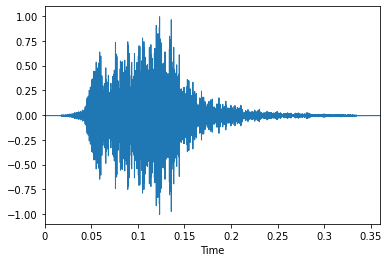

In [58]:
#Compute melspectrogram:
#https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
#import librosa
audio_sample_path  =  AUDIO_DS_PATH /"1-100032-A-0.wav"

def pre_process_stem(audio_path:Path):
    y, sr = librosa.load(audio_path, 44100)
    audio_sample, _  = librosa.effects.trim(y)
    return audio_sample
audio_stem = pre_process_stem(audio_sample_path)
librosa.display.waveplot(audio_sample, sr=sr)


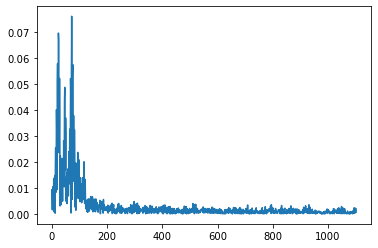

In [63]:
#apply fourier transform
n_fft = 2205
fft_stem = np.abs(librosa.stft(audio_stem[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(fft_stem);

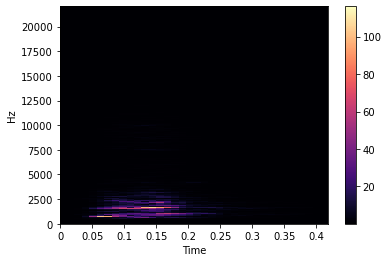

In [60]:
hop_length = 441
D = np.abs(librosa.stft(audio_stem, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

C:\Users\drumm\anaconda3\envs\vhc\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\drumm\anaconda3\envs\vhc\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\drumm\anaconda3\envs\vhc\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


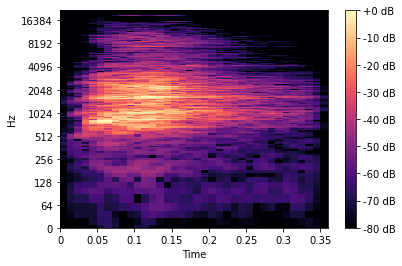

In [61]:
#transform: y-axi (frequency) to log-scale
#color (amplitud) to Decibels
def apply_log_db(audio_stem):
    DB = librosa.amplitude_to_db(D, ref=np.max)
    return DB
db_scaled_stem = apply_log_db(audio_stem)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

In [ ]:
r_settings= {
    "sr" : 44100,
    "n_fft" : 2205,
    "hop_length" : 441,
    "win_length" : 442,
    "n_mels" : 32,
    "fmin" : 10,
    "fmax" : 22050,
    }

def compute_mels(settings, y):
    mels = meslpectrogram(y,
                          sr= settings['sr'],
                          n_mels= settings['n_mels'],
                          n_fft=settings['n_fft'],
                          hop_length=settings['hop_length'])
    return mels
def load_audio_windows(audio_path:Path, settings):
    y, sr =librosa.load(audio_path, settings['sr'])
    S = librosa.core.stft(y,n_fft=settings['n_fft'])
    magnitude = np.abs(S)**2
    mels = compute_mels(settings, y=y)
    #truncate at end to only have windows full data. Alternative: zero-pad
    mel = librosa.filters.mel(sr=settings['sr'],
                              n_fft=settings['n_fft'],
                              n_mels = settings['n_mels'])